<a href="https://colab.research.google.com/github/dolmani38/non-linear-regression/blob/master/Regession_test_0804.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install lime

import numpy as np
import pandas as pd
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization
from keras.layers import Input, Embedding, Dense
from keras.models import Model
from keras.callbacks import Callback
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from lime import lime_tabular, lime_text
from keras.utils import to_categorical
import datetime
import random

# Bayesian Methods for Hackers style sheet
plt.style.use('bmh')

np.random.seed(1234567890)

from keras import backend as K

def r2(y_true, y_pred):
    """
    # custom R2-score metrics for keras backend
    :param y_true: 실측 데이터
    :param y_pred: 모델에 의한 예측 데이테
    :return: R^2 value, 이 값이 높다고 (예:0.99)해서 예측 값이 정확 하다고 할 수 는 없음...
    """
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - SS_res / (SS_tot + K.epsilon()))

def soft_100_acc(y_true, y_pred):
    delta = 100
    return K.mean(K.less_equal(K.abs(y_true-y_pred),delta))

def soft_300_acc(y_true, y_pred):
    delta = 300
    return K.mean(K.less_equal(K.abs(y_true-y_pred),delta))

def structure(df):
    """
    DataFrame의 column 등 전반적인 구조를 표출 한다.
    :param df:
    :return:
    """
    df1 = df.describe(include='all').T
    df1['type'] = df.dtypes
    df1['null count'] = df.isnull().sum()
    if 'freq' in df1.columns:
        df2 = df1[
            ['type', 'count', 'null count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max', 'unique', 'top',
             'freq']]
    else:
        df2 = df1[['type', 'count', 'null count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']]

    return df2

class VerboseCallback(keras.callbacks.Callback):
    """
    kerase.model.fit 함수에서, log 출력을 위한 callback
    """
    def __init__(self, epoch):
        self.epoch = epoch
        self.progress("learning:", 0, [])

    def progress(self, text, current=0, log=None):
        g = self.epoch - current
        f = 50 / self.epoch
        c = int(current * f)
        pg = ['=' for i in range(c)] + ['.' for i in range(50 - c)]
        print("\r" + str(text) + "{}/{}[{}]{}".format(current, self.epoch, ''.join(pg), ('' if log is None else str(log).strip())),
              end="", flush=True)
        if self.epoch - current == 0:
            print("")

    def on_epoch_end(self, epoch, logs=None):
        self.progress("learning:", epoch + 1, logs)


class PeriodicLogger(Callback):
    """
    A helper callback class that only prints the losses once in 'display' epochs
    """
    def __init__(self, display=100):
        self.display = display

    def on_train_begin(self, logs={}):      
        self.epochs = 0    

    def on_epoch_end(self, batch, logs={}):    
        self.epochs += 1     
        if self.epochs % self.display == 0:
            print ("Epoch: %d - %s" % (self.epochs, str(logs)))

periodic_logger_10 = PeriodicLogger(10) 
periodic_logger_50 = PeriodicLogger(50)
periodic_logger_250 = PeriodicLogger(250)
periodic_logger_1000 = PeriodicLogger(1000)

     |████████████████████████████████| 276kB 7.0MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-cp36-none-any.whl size=283845 sha256=1f43262961afc9ee8c6a694756619feb13ae7211f96e132a12a0a1c33273ff8b
  Stored in directory: /root/.cache/pip/wheels/4c/4f/a5/0bc765457bd41378bf3ce8d17d7495369d6e7ca3b712c60c89
Successfully built lime


In [2]:
def nafyc_func(row):
    code,real_yy,rate = row['CODE'],row['REAL_YY'],row['COM_RATE']
    return real_yy * rate

In [45]:
def create_samples(n_samples):
    rate_table = {}
    samples = []
    for i in range(1000,1520):
      code = i #np.random.choice(range(1000,1520))
      count = np.random.choice(range(10,500))
      for j in range(count):
        real_yy = random.choice(range(1000)) * random.choice(range(1000))
        if code not in rate_table:
          rate = np.random.choice(range(100)) / 100
          rate_table[code] = rate
        else:
          rate = rate_table[code]
        samples.append([code,real_yy,rate])
        
    return pd.DataFrame(samples, columns=['CODE','REAL_YY','COM_RATE'])

In [46]:
dataset = create_samples(n_samples=1000)
dataset['NAFYC'] = dataset.apply(nafyc_func, axis=1)
dataset

,CODE,REAL_YY,COM_RATE,NAFYC
0,1000,440100,0.67,294867.00
1,1000,51048,0.67,34202.16
2,1000,299899,0.67,200932.33
3,1000,166385,0.67,111477.95
4,1000,487375,0.67,326541.25
...,...,...,...,...
140097,1519,76818,0.81,62222.58
140098,1519,107520,0.81,87091.20
140099,1519,124221,0.81,100619.01
140100,1519,434145,0.81,351657.45


In [47]:
structure(dataset)

,type,count,null count,mean,std,min,25%,50%,75%,max
CODE,int64,140102.0,0,1258.461485,149.821130,1000.0,1130.000,1255.00,1392.0000,1519.00
REAL_YY,int64,140102.0,0,249094.121390,219789.433000,0.0,67165.250,185603.00,382276.5000,993012.00
COM_RATE,float64,140102.0,0,0.513239,0.294305,0.0,0.250,0.54,0.7700,0.99
NAFYC,float64,140102.0,0,127667.587318,149215.205807,0.0,18913.065,70277.88,183887.9775,975203.46


In [48]:
dataset = dataset.astype({"CODE": object})

In [49]:
structure(dataset)

,type,count,null count,mean,std,min,25%,50%,75%,max,unique,top,freq
CODE,object,140102.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,520.0,1005.0,497.0
REAL_YY,int64,140102.0,0,249094.121390,219789.433000,0.0,67165.250,185603.00,382276.5000,993012.00,NaN,NaN,NaN
COM_RATE,float64,140102.0,0,0.513239,0.294305,0.0,0.250,0.54,0.7700,0.99,NaN,NaN,NaN
NAFYC,float64,140102.0,0,127667.587318,149215.205807,0.0,18913.065,70277.88,183887.9775,975203.46,NaN,NaN,NaN


In [50]:
dataset[dataset['CODE'] == 1386]

,CODE,REAL_YY,COM_RATE,NAFYC
103647,1386,36045,0.74,26673.30
103648,1386,316938,0.74,234534.12
103649,1386,650791,0.74,481585.34
103650,1386,11685,0.74,8646.90
103651,1386,6210,0.74,4595.40
...,...,...,...,...
104054,1386,661429,0.74,489457.46
104055,1386,645012,0.74,477308.88
104056,1386,928071,0.74,686772.54
104057,1386,414814,0.74,306962.36


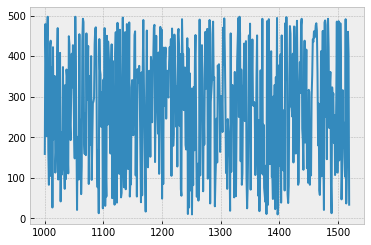

In [51]:
plt.plot(dataset.groupby('CODE')['CODE'].count())

In [52]:
# zscore norm

ds = dataset[['REAL_YY','COM_RATE']]

_mean = ds.mean(axis=0)
_std = ds.std(axis=0)

ds = ds - _mean
ds /= _std

dataset.update(ds)
dataset

,CODE,REAL_YY,COM_RATE,NAFYC
0,1000,0.869040,0.532648,294867.00
1,1000,-0.901072,0.532648,34202.16
2,1000,0.231153,0.532648,200932.33
3,1000,-0.376311,0.532648,111477.95
4,1000,1.084133,0.532648,326541.25
...,...,...,...,...
140097,1519,-0.783823,1.008344,62222.58
140098,1519,-0.644135,1.008344,87091.20
140099,1519,-0.568149,1.008344,100619.01
140100,1519,0.841946,1.008344,351657.45


In [53]:
class EmbeddingMapping():
    """
    Helper class for handling categorical variables
    An instance of this class should be defined for each categorical variable we want to use.
    """
    def __init__(self, series):
        # get a list of unique values
        values = series.unique().tolist()
        
        # Set a dictionary mapping from values to integer value
        # In our example this will be {'Mercaz': 1, 'Old North': 2, 'Florentine': 3}
        self.embedding_dict = {value: int_value+1 for int_value, value in enumerate(values)}
        
        # The num_values will be used as the input_dim when defining the embedding layer. 
        # It will also be returned for unseen values 
        self.num_values = len(values) + 1

    def get_mapping(self, value):
        # If the value was seen in the training set, return its integer mapping
        if value in self.embedding_dict:
            return self.embedding_dict[value]
        
        # Else, return the same integer for unseen values
        else:
            return self.num_values

In [54]:
code_mapping = EmbeddingMapping(dataset['CODE'])
dataset = dataset.assign(code_mapping=dataset['CODE'].apply(code_mapping.get_mapping))
dataset

,CODE,REAL_YY,COM_RATE,NAFYC,code_mapping
0,1000,0.869040,0.532648,294867.00,1
1,1000,-0.901072,0.532648,34202.16,1
2,1000,0.231153,0.532648,200932.33,1
3,1000,-0.376311,0.532648,111477.95,1
4,1000,1.084133,0.532648,326541.25,1
...,...,...,...,...,...
140097,1519,-0.783823,1.008344,62222.58,520
140098,1519,-0.644135,1.008344,87091.20,520
140099,1519,-0.568149,1.008344,100619.01,520
140100,1519,0.841946,1.008344,351657.45,520


In [55]:
# trainset과 validationset 나누고... 기타 정리

X_train_org, X_val_org, Y_train, Y_val = train_test_split(dataset[['REAL_YY','code_mapping']],
    dataset['NAFYC'], test_size=0.1, random_state=0)

# 학습 대상 변수만 선택
X_train_continuous = X_train_org[['REAL_YY']]
X_train_categorical = X_train_org[['code_mapping']]

X_val_continuous  = X_val_org[['REAL_YY']]
X_val_categorical = X_val_org[['code_mapping']]


In [56]:
# Define the embedding input
code_input = Input(shape=(1,), dtype='int32') 
output_dim=32*2   #X_train_categorical['code_mapping'].max()*1
code_embedings = Embedding(output_dim=output_dim, input_dim=X_train_categorical['code_mapping'].max()+1)(code_input)
code_embedings = keras.layers.Reshape((output_dim,))(code_embedings)

In [57]:
# Define the continuous variables input (just like before)
continuous_input = Input(shape=(X_train_continuous.shape[1], ))

# Concatenate continuous and embeddings inputs
all_input = keras.layers.concatenate([continuous_input, code_embedings])
print(all_input)

Tensor("concatenate_2/concat:0", shape=(None, 65), dtype=float32)


In [58]:
# Define the model
dense1 = Dense(all_input.shape[1]*3, activation='relu')(all_input)
dense2 = Dense(5, activation='relu')(dense1)
predictions = Dense(1)(dense2)

# Note using the input object 'area_input' not 'area_embeddings'
model = Model(inputs=[continuous_input, code_input], outputs=predictions)
model.compile(loss='mse', optimizer=keras.optimizers.Adam(lr=.8, beta_1=0.9, beta_2=0.999, decay=1e-03, amsgrad=True),metrics=[soft_100_acc,soft_300_acc,r2])
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 64)        33344       input_5[0][0]                    
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
reshape_2 (Reshape)             (None, 64)           0           embedding_2[0][0]                
_______________________________________________________________________________________

In [60]:
epochs = 100

# Note continuous and categorical columns are inserted in the same order as defined in all_inputs
history = model.fit([X_train_continuous, X_train_categorical['code_mapping']], Y_train, 
          epochs=epochs, batch_size=128, 
          callbacks=[periodic_logger_10], verbose=0,
          validation_data=([X_val_continuous, X_val_categorical['code_mapping']], Y_val))

Epoch: 10 - {'loss': 199068.625, 'soft_100_acc': 0.44027966260910034, 'soft_300_acc': 0.8452187180519104, 'r2': 0.9999938011169434, 'val_loss': 251253.828125, 'val_soft_100_acc': 0.44537630677223206, 'val_soft_300_acc': 0.8293420076370239, 'val_r2': 0.9999884366989136}
Epoch: 20 - {'loss': 190469.03125, 'soft_100_acc': 0.4618292450904846, 'soft_300_acc': 0.8573178052902222, 'r2': 0.9999942779541016, 'val_loss': 239333.78125, 'val_soft_100_acc': 0.4364154040813446, 'val_soft_300_acc': 0.8454051613807678, 'val_r2': 0.999988853931427}
Epoch: 30 - {'loss': 184175.625, 'soft_100_acc': 0.47478118538856506, 'soft_300_acc': 0.8667675852775574, 'r2': 0.9999940991401672, 'val_loss': 228540.578125, 'val_soft_100_acc': 0.4465487599372864, 'val_soft_300_acc': 0.8550763130187988, 'val_r2': 0.99998939037323}
Epoch: 40 - {'loss': 179216.984375, 'soft_100_acc': 0.48594528436660767, 'soft_300_acc': 0.8734527826309204, 'r2': 0.999994695186615, 'val_loss': 222579.796875, 'val_soft_100_acc': 0.463618308305

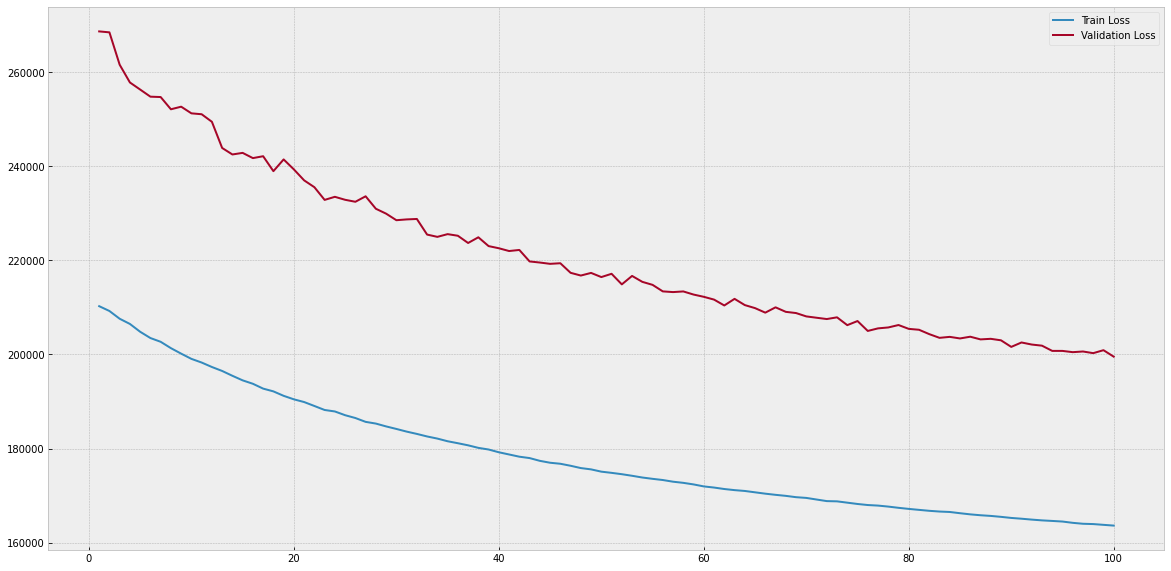

In [61]:
# Plot the train/validation loss values
plt.figure(figsize=(20,10))
_loss = history.history['loss'][0:]
_val_loss = history.history['val_loss'][0:]

train_loss_plot, = plt.plot(range(1, len(_loss)+1), _loss, label='Train Loss')
val_loss_plot, = plt.plot(range(1, len(_val_loss)+1), _val_loss, label='Validation Loss')

_ = plt.legend(handles=[train_loss_plot, val_loss_plot])

This is the average value we are trying to predict: 128759
The mean is very close to 0 (-0.08) with std. 446.71.


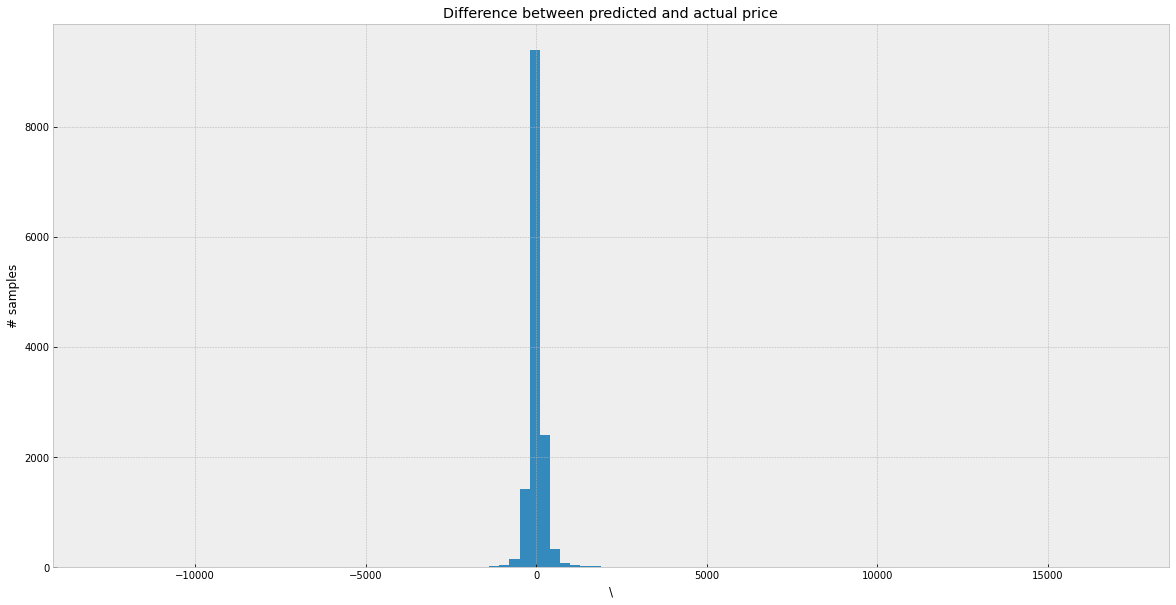

,pred,diff,abs_diff,%diff,abs_%diff,CODE,REAL_YY,COM_RATE,NAFYC,code_mapping
128552,124770.460938,17064.940937,17064.940937,15.844073,15.844073,1476,2.636204,-1.302181,107705.52,477
97780,422981.750000,15343.400000,15343.400000,3.763974,3.763974,1357,2.988173,-0.214875,407638.35,358
41875,22.480124,-12685.039876,12685.039876,-99.823096,99.823096,1156,1.757509,-1.675943,12707.52,157
97844,412354.781250,12682.781250,12682.781250,3.173297,3.173297,1357,2.907628,-0.214875,399672.00,358
41717,327668.343750,8774.593750,8774.593750,2.751573,2.751573,1155,3.012114,-0.554658,318893.75,156
15386,580622.187500,8768.187500,8768.187500,1.533291,1.533291,1058,3.203047,0.294800,571854.00,59
41843,22.480124,-8098.959876,8098.959876,-99.723200,99.723200,1156,0.714219,-1.675943,8121.44,157
1003,406243.031250,8051.851250,8051.851250,2.022107,2.022107,1002,3.285435,-0.350789,398191.18,3
41998,22.480124,-7591.299876,7591.299876,-99.704744,99.704744,1156,0.598732,-1.675943,7613.78,157
41936,22.480124,-7097.699876,7097.699876,-99.684276,99.684276,1156,0.486442,-1.675943,7120.18,157


In [64]:
df = pd.DataFrame(Y_val,columns=['NAFYC'])

print ("This is the average value we are trying to predict: %d" % df['NAFYC'].mean())

# Add a column for the model's predicted values
df['pred'] = model.predict([X_val_continuous, X_val_categorical['code_mapping']])

# Calculate the difference between the predicted and the actual price
df['diff'] = df['pred'] - df['NAFYC']

# Calculate the absolute difference between the predicted and the actual price
df['abs_diff'] = np.abs(df['diff'])

# Calculate the percentage of the difference from the actual price
df['%diff'] = 100 * (df['diff'] / df['NAFYC'])

# Calculate the absolute percentage difference from the actual price
df['abs_%diff'] = np.abs(df['%diff'])

# Calculate the mean and std. of the diff field
diff_mean, diff_std = df['diff'].mean(), df['diff'].std()
print("The mean is very close to 0 ({mean}) with std. {std}.".format(mean=round(diff_mean, 2), std=round(diff_std, 2)))

# Here is the histogram of the differences
plt.figure(figsize=(20,10))
plt.hist(df['diff'], bins=100)
plt.xlabel("\\")
plt.ylabel("# samples")
_ = plt.title("Difference between predicted and actual price")

plt.show()

# Sort by the 'abs_diff' field and show the 5 largest mistakes in absolute values
a = df.sort_values("abs_diff", ascending=False)
a.drop(columns=['NAFYC'],inplace=True)
b = a.join(dataset)
b.head(10)

In [71]:
dataset[dataset['code_mapping']==3]

,CODE,REAL_YY,COM_RATE,NAFYC,code_mapping
638,1002,-0.398746,-0.350789,66196.14,3
639,1002,1.345692,-0.350789,223393.83,3
640,1002,0.921864,-0.350789,185201.10,3
641,1002,0.591661,-0.350789,155445.35,3
642,1002,-1.073078,-0.350789,5429.63,3
...,...,...,...,...,...
1026,1002,1.613075,-0.350789,247488.71,3
1027,1002,0.110678,-0.350789,112102.20,3
1028,1002,-0.530244,-0.350789,54346.32,3
1029,1002,-0.877795,-0.350789,23027.24,3


In [72]:
dataset

,CODE,REAL_YY,COM_RATE,NAFYC,code_mapping
0,1000,0.869040,0.532648,294867.00,1
1,1000,-0.901072,0.532648,34202.16,1
2,1000,0.231153,0.532648,200932.33,1
3,1000,-0.376311,0.532648,111477.95,1
4,1000,1.084133,0.532648,326541.25,1
...,...,...,...,...,...
140097,1519,-0.783823,1.008344,62222.58,520
140098,1519,-0.644135,1.008344,87091.20,520
140099,1519,-0.568149,1.008344,100619.01,520
140100,1519,0.841946,1.008344,351657.45,520


In [77]:
dataset['ft1'] = dataset['REAL_YY']* dataset['COM_RATE']

In [78]:
dataset

,CODE,REAL_YY,COM_RATE,NAFYC,code_mapping,ft1
0,1000,0.869040,0.532648,294867.00,1,0.462892
1,1000,-0.901072,0.532648,34202.16,1,-0.479954
2,1000,0.231153,0.532648,200932.33,1,0.123123
3,1000,-0.376311,0.532648,111477.95,1,-0.200441
4,1000,1.084133,0.532648,326541.25,1,0.577461
...,...,...,...,...,...,...
140097,1519,-0.783823,1.008344,62222.58,520,-0.790364
140098,1519,-0.644135,1.008344,87091.20,520,-0.649510
140099,1519,-0.568149,1.008344,100619.01,520,-0.572890
140100,1519,0.841946,1.008344,351657.45,520,0.848972


In [79]:
# trainset과 validationset 나누고... 기타 정리

X_train_org, X_val_org, Y_train, Y_val = train_test_split(dataset[['REAL_YY','ft1','code_mapping']],
    dataset['NAFYC'], test_size=0.1, random_state=0)

# 학습 대상 변수만 선택
X_train_continuous = X_train_org[['REAL_YY','ft1']]
X_train_categorical = X_train_org[['code_mapping']]

X_val_continuous  = X_val_org[['REAL_YY','ft1']]
X_val_categorical = X_val_org[['code_mapping']]


In [80]:
# Define the embedding input
code_input = Input(shape=(1,), dtype='int32') 
output_dim=32*2   #X_train_categorical['code_mapping'].max()*1
code_embedings = Embedding(output_dim=output_dim, input_dim=X_train_categorical['code_mapping'].max()+1)(code_input)
code_embedings = keras.layers.Reshape((output_dim,))(code_embedings)

# Define the continuous variables input (just like before)
continuous_input = Input(shape=(X_train_continuous.shape[1], ))

# Concatenate continuous and embeddings inputs
all_input = keras.layers.concatenate([continuous_input, code_embedings])
print(all_input)

# Define the model
dense1 = Dense(all_input.shape[1]*3, activation='relu')(all_input)
dense2 = Dense(5, activation='relu')(dense1)
predictions = Dense(1)(dense2)

# Note using the input object 'area_input' not 'area_embeddings'
model = Model(inputs=[continuous_input, code_input], outputs=predictions)
model.compile(loss='mse', optimizer=keras.optimizers.Adam(lr=.8, beta_1=0.9, beta_2=0.999, decay=1e-03, amsgrad=True),metrics=[soft_100_acc,soft_300_acc,r2])
model.summary()

Tensor("concatenate_4/concat:0", shape=(None, 66), dtype=float32)
Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 1, 64)        33344       input_10[0][0]                   
__________________________________________________________________________________________________
input_11 (InputLayer)           [(None, 2)]          0                                            
__________________________________________________________________________________________________
reshape_5 (Reshape)             (None, 64)           0           embedding_5[0][0]                
_____________________

In [81]:
epochs = 100

# Note continuous and categorical columns are inserted in the same order as defined in all_inputs
history = model.fit([X_train_continuous, X_train_categorical['code_mapping']], Y_train, 
          epochs=epochs, batch_size=128, 
          callbacks=[periodic_logger_10], verbose=0,
          validation_data=([X_val_continuous, X_val_categorical['code_mapping']], Y_val))

Epoch: 10 - {'loss': 108848.2578125, 'soft_100_acc': 0.3326968252658844, 'soft_300_acc': 0.7578319311141968, 'r2': 0.9999989867210388, 'val_loss': 130725.421875, 'val_soft_100_acc': 0.33555227518081665, 'val_soft_300_acc': 0.7703810930252075, 'val_r2': 0.9999939799308777}
Epoch: 20 - {'loss': 71155.0703125, 'soft_100_acc': 0.4218267500400543, 'soft_300_acc': 0.8397595286369324, 'r2': 0.9999995231628418, 'val_loss': 85035.65625, 'val_soft_100_acc': 0.43583759665489197, 'val_soft_300_acc': 0.838528037071228, 'val_r2': 0.9999966025352478}
Epoch: 30 - {'loss': 59136.3046875, 'soft_100_acc': 0.4671480059623718, 'soft_300_acc': 0.867734968662262, 'r2': 0.9999995827674866, 'val_loss': 73001.328125, 'val_soft_100_acc': 0.47271043062210083, 'val_soft_300_acc': 0.8592666387557983, 'val_r2': 0.9999973177909851}
Epoch: 40 - {'loss': 52773.83984375, 'soft_100_acc': 0.4947878420352936, 'soft_300_acc': 0.8832828998565674, 'r2': 0.9999997019767761, 'val_loss': 66519.6875, 'val_soft_100_acc': 0.4860747

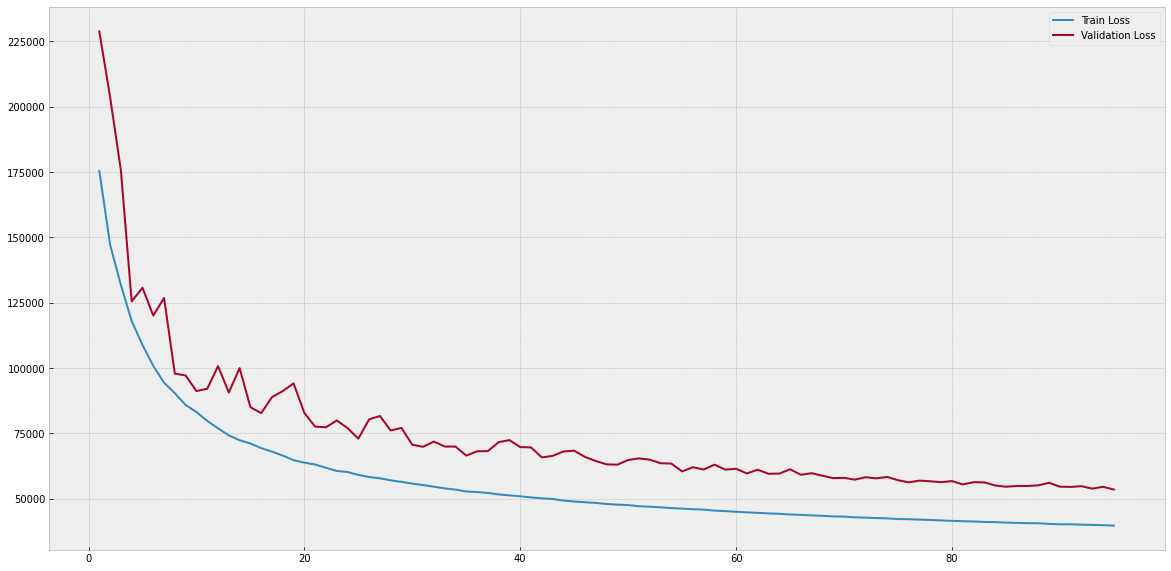

In [89]:
# Plot the train/validation loss values
plt.figure(figsize=(20,10))
_loss = history.history['loss'][5:]
_val_loss = history.history['val_loss'][5:]

train_loss_plot, = plt.plot(range(1, len(_loss)+1), _loss, label='Train Loss')
val_loss_plot, = plt.plot(range(1, len(_val_loss)+1), _val_loss, label='Validation Loss')

_ = plt.legend(handles=[train_loss_plot, val_loss_plot])

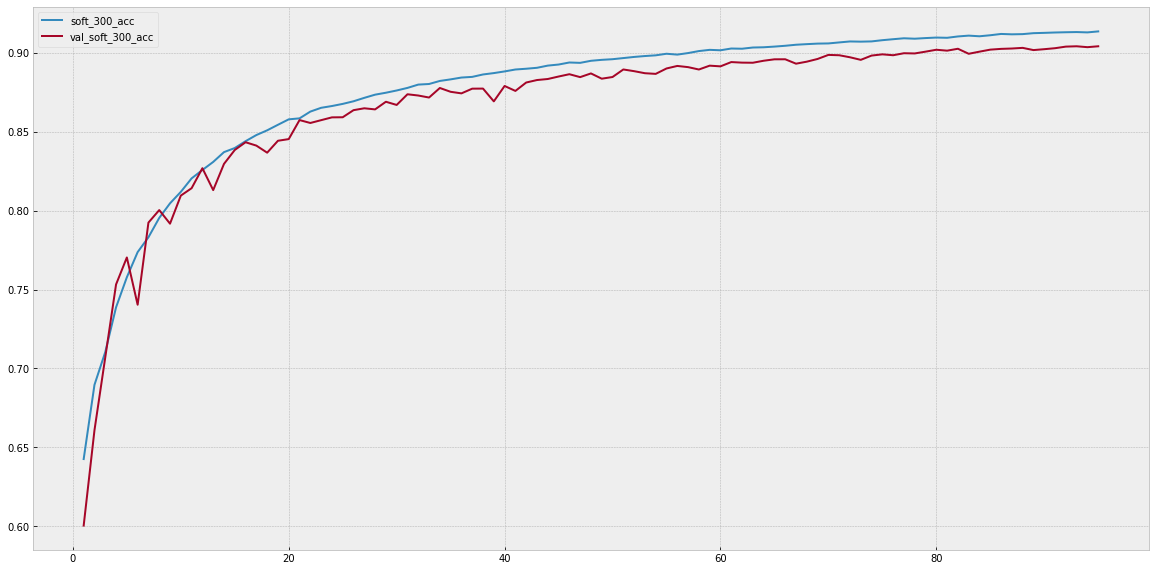

In [90]:
plt.figure(figsize=(20,10))
_loss = history.history['soft_300_acc'][5:]
_val_loss = history.history['val_soft_300_acc'][5:]

train_loss_plot, = plt.plot(range(1, len(_loss)+1), _loss, label='soft_300_acc')
val_loss_plot, = plt.plot(range(1, len(_val_loss)+1), _val_loss, label='val_soft_300_acc')

_ = plt.legend(handles=[train_loss_plot, val_loss_plot])

This is the average value we are trying to predict: 128759
The mean is very close to 0 (6.22) with std. 231.29.


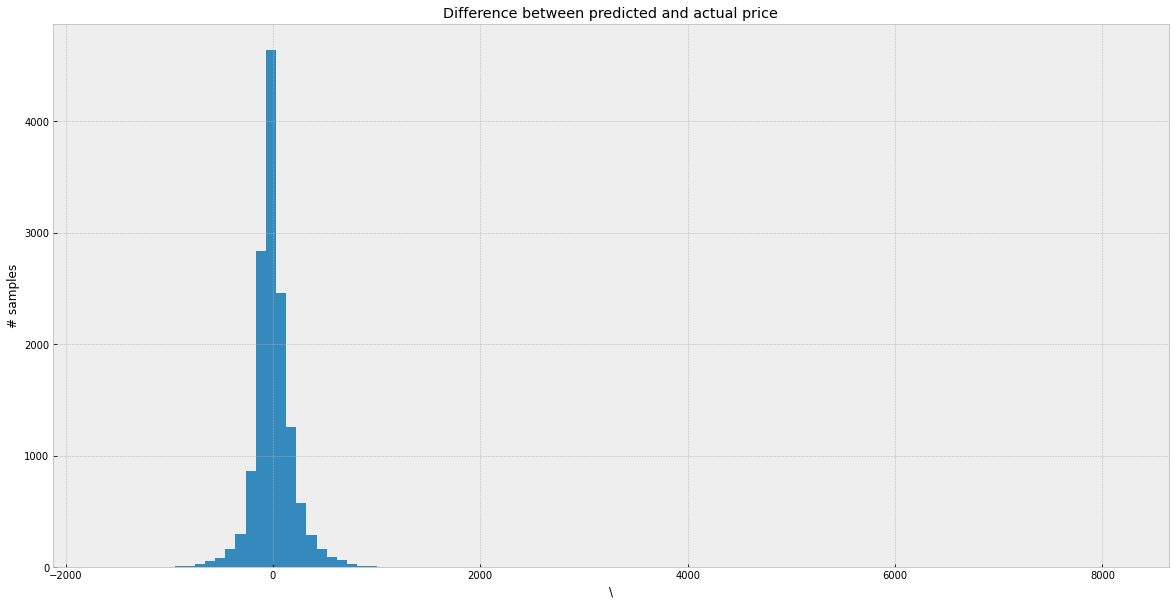

,pred,diff,abs_diff,%diff,abs_%diff,CODE,REAL_YY,COM_RATE,NAFYC,code_mapping,ft1
132673,8919.199219,8150.799219,8150.799219,1060.749508,1060.749508,1489,-1.112766,-1.166268,768.40,490,1.297783
132670,11851.932617,7363.252617,7363.252617,164.040489,164.040489,1489,-1.013198,-1.166268,4488.68,490,1.181660
132674,20769.318359,5438.718359,5438.718359,35.476226,35.476226,1489,-0.723029,-1.166268,15330.60,490,0.843246
35071,834736.062500,2918.262500,2918.262500,0.350830,0.350830,1131,3.071794,1.314149,831817.80,132,4.036795
128781,11611.818359,2635.818359,2635.818359,29.365178,29.365178,1477,2.950578,-1.709921,8976.00,478,-5.045256
25842,564441.062500,2334.062500,2334.062500,0.415235,0.415235,1095,3.276117,0.226843,562107.00,96,0.743164
31002,429763.625000,2239.125000,2239.125000,0.523742,0.523742,1115,2.756979,-0.044984,427524.50,116,-0.124019
65510,348218.281250,2236.831250,2236.831250,0.646518,0.646518,1235,3.121128,-0.486702,345981.45,236,-1.519058
25862,550805.687500,2036.947500,2036.947500,0.371185,0.371185,1095,3.171485,0.226843,548768.74,96,0.719429
45827,387491.406250,1998.126250,1998.126250,0.518330,0.518330,1171,2.945555,-0.282832,385493.28,172,-0.833097


In [82]:
df = pd.DataFrame(Y_val,columns=['NAFYC'])

print ("This is the average value we are trying to predict: %d" % df['NAFYC'].mean())

# Add a column for the model's predicted values
df['pred'] = model.predict([X_val_continuous, X_val_categorical['code_mapping']])

# Calculate the difference between the predicted and the actual price
df['diff'] = df['pred'] - df['NAFYC']

# Calculate the absolute difference between the predicted and the actual price
df['abs_diff'] = np.abs(df['diff'])

# Calculate the percentage of the difference from the actual price
df['%diff'] = 100 * (df['diff'] / df['NAFYC'])

# Calculate the absolute percentage difference from the actual price
df['abs_%diff'] = np.abs(df['%diff'])

# Calculate the mean and std. of the diff field
diff_mean, diff_std = df['diff'].mean(), df['diff'].std()
print("The mean is very close to 0 ({mean}) with std. {std}.".format(mean=round(diff_mean, 2), std=round(diff_std, 2)))

# Here is the histogram of the differences
plt.figure(figsize=(20,10))
plt.hist(df['diff'], bins=100)
plt.xlabel("\\")
plt.ylabel("# samples")
_ = plt.title("Difference between predicted and actual price")

plt.show()

# Sort by the 'abs_diff' field and show the 5 largest mistakes in absolute values
a = df.sort_values("abs_diff", ascending=False)
a.drop(columns=['NAFYC'],inplace=True)
b = a.join(dataset)
b.head(10)

In [92]:
train_ds = pd.concat([X_train_continuous,X_train_categorical], axis=1)
val_ds = pd.concat([X_val_continuous,X_val_categorical], axis=1)

# XAI를 위한 lime  정의
from lime import lime_tabular, lime_text
exp = lime_tabular.LimeTabularExplainer(
    train_ds.to_numpy(),
    training_labels=Y_train,
    feature_names=train_ds.columns,
    class_names= ['NAFYC'],
    mode="regression"
)

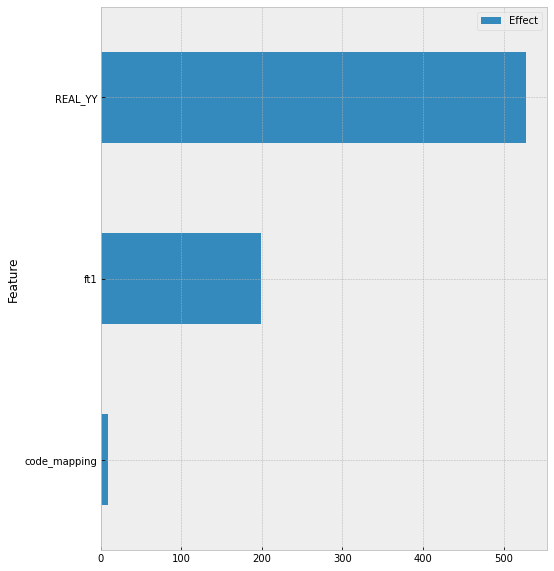

,Feature,Effect
0,code_mapping,9.660061
1,ft1,198.400488
2,REAL_YY,527.287845


In [95]:
# 변수의 영향력 분석
# 소팅을 위한 초기화 
exp_ana = {}
for k in train_ds.columns:
  exp_ana[k] = 0

# predict 함수 재정의 - lime에서 사용 가능하도록...
continue_dim = X_train_continuous.shape[1]
input_dim = train_ds.shape[1]
def predict(data):
    return model.predict([data[:,0:continue_dim],data[:,continue_dim:input_dim]])

# validation set의 변수 영향력 분석...
for i in range(40): #range(val_ds.shape[0]):
    p = exp.explain_instance(np.asarray(val_ds.iloc[i]),predict,num_features=val_ds.shape[1])
    for t in p.as_map()[0]:
      exp_ana[train_ds.columns[t[0]]] += np.abs(t[1])

import operator

sorted_x = sorted(exp_ana.items(), key=operator.itemgetter(1))

effect_result_table = pd.DataFrame(sorted_x,columns=['Feature', 'Effect'])
effect_result_table['Effect'] = effect_result_table['Effect']/10000
effect_result_table.plot(x='Feature',y='Effect', figsize=(8, 10),kind='barh')
plt.show()
effect_result_table